## Big Data in Finance Group Assignment 2

### Foreign Exchange Predictive Model

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

%matplotlib inline

#### Read Data

In [5]:
fxSpot = pd.read_excel('FX.xlsx', sheetname = 'FX_Spot', index_col = 'Date')
eurDep = pd.read_excel('FX.xlsx', sheetname = 'EuroDep', index_col = 'Date')
mSupply = pd.read_excel('FX.xlsx', sheetname = 'MoneySupply', index_col = 'Date')
indPrd = pd.read_excel('FX.xlsx', sheetname = 'IndProduction', index_col = 'Date')
cpi = pd.read_excel('FX.xlsx', sheetname = 'CPI', index_col = 'Date')

#### Variable Construction

In [6]:
# Y variable for all currencies
spotDelta_Matrix = np.diff(np.log(fxSpot.as_matrix()), axis = 0)
spotDelta_Matrix = np.insert(spotDelta_Matrix, 0, np.nan, axis = 0)
fxSpotDelta = pd.DataFrame(spotDelta_Matrix, index = fxSpot.index, columns = fxSpot.columns)

# X1 variable
intUSD = eurDep['USD'].as_matrix()
intDiff_Matrix = (eurDep.as_matrix().transpose() - intUSD).transpose()
intDiff = pd.DataFrame(intDiff_Matrix, index = eurDep.index, columns = eurDep.columns)

# X2 variable
inflDelta_Matrix = np.diff(np.log(cpi.as_matrix()), axis = 0)
inflDelta_Matrix = np.insert(inflDelta_Matrix, 0, np.nan, axis = 0)
inflDelta_US = inflDelta_Matrix[ : , inflDelta_Matrix.shape[1] - 1]
inflDiff_Matrix = (inflDelta_Matrix.transpose() - inflDelta_US).transpose()
inflDiff = pd.DataFrame(inflDiff_Matrix, index = cpi.index, columns = cpi.columns)

# X3 variable
indPrd_logMatrix = np.log(indPrd.as_matrix())
indPrd_logUS = indPrd_logMatrix[ : , indPrd_logMatrix.shape[1] - 1]
indPrdDiff_Matrix = (indPrd_logMatrix.transpose() - indPrd_logUS).transpose()
indPrdDiff = pd.DataFrame(indPrdDiff_Matrix, index = indPrd.index, columns = indPrd.columns)

# X4 variable
mSupply_logMatrix = np.log(mSupply.as_matrix())
mSupply_logUS = mSupply_logMatrix[ : , mSupply_logMatrix.shape[1] - 1]
mSupplyDiff_Matrix = (mSupply_logMatrix.transpose() - mSupply_logUS).transpose()
mSupplyDiff = pd.DataFrame(mSupplyDiff_Matrix, index = mSupply.index, columns = mSupply.columns)

#### Rolling Window Method and Plot

In [13]:
def learnAndPlot(windowSize, model, fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff):
    # Windows Size
    w = windowSize

    # Random Forest Param Grid
    #param_grid = {"min_samples_leaf": [1, 3, 10]}

    cumDiffList = [] # Cumulative RMSE difference between prediction model and historical mean
    for currency in fxSpotDelta.columns.values:
        print("Currency = ", currency)
        histMeanMSE = []
        modelMSE = []
        for yIdx in range(2, fxSpotDelta.shape[0] - w): # First y(i+1) ranges from 3 to 384
            #print("yIdx = ", yIdx)
            xIdx = yIdx - 1
            yMat = fxSpotDelta[currency].as_matrix()
            x1Mat = intDiff[currency].as_matrix()
            x2Mat = inflDiff[currency].as_matrix()
            x3Mat = indPrdDiff[currency].as_matrix()
            x4Mat = mSupplyDiff[currency].as_matrix()
            Y = yMat[yIdx:(yIdx + w)]
            X1 = x1Mat[xIdx:(xIdx + w)]
            X2 = x2Mat[xIdx:(xIdx + w)]
            X3 = x3Mat[xIdx:(xIdx + w)]
            X4 = x4Mat[xIdx:(xIdx + w)]
            X = np.vstack((X1, X2, X3, X4)).T
            # Linear Regression Model
            #model = linear_model.LinearRegression()
            # LASSO with 10-fold cross validation to select the best alpha
            #model = linear_model.LassoCV(cv = 10)
            # Random Forest without Cross Validation
            #model = ensemble.RandomForestRegressor(n_estimators = 20)
            # Random Forest with Grid Search CV
            #model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, cv = 10)
            model.fit(X, Y)
            PredX = np.array([[x1Mat[xIdx + w], x2Mat[xIdx + w], x3Mat[xIdx + w], x4Mat[xIdx + w]]])
            YhistPred = np.mean(Y)
            YModelPred = model.predict(PredX)
            actY = yMat[yIdx + w]
            histMeanMSE.append((YhistPred - actY)**2)
            modelMSE.append((YModelPred[0] - actY)**2)

        # RMSE
        histMeanRMSE = np.sqrt(np.array(histMeanMSE))
        linRegrRMSE= np.sqrt(np.array(modelMSE))
        diffRMSE = histMeanRMSE - linRegrRMSE

        cumDiffList.append(np.insert(diffRMSE.cumsum(), 0, np.zeros(2 + w)))

    cumDiff = np.array(cumDiffList).transpose()

    datesList = [datetime.strptime(str(date), '%Y%m').date() for date in fxSpotDelta.index.values]
    for i in range(cumDiff.shape[1]):
        plt.plot(datesList, cumDiff[:, i], label = fxSpotDelta.columns.values[i])
    plt.legend()
    plt.show()
    plt.close()
    
    return cumDiff

#### Learn With Linear Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


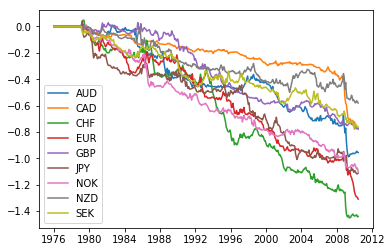

In [14]:
# Linear Regression
linRegrCumDiff = learnAndPlot(36, linear_model.LinearRegression(), fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

#### Learn With LASSO Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


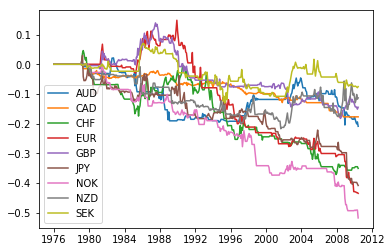

In [15]:
# LASSO Regression with alphas selected by 10-fold Cross Validation
lassoCumDiff = learnAndPlot(36, linear_model.LassoCV(cv = 10), fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

#### Learn With Random Forest Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


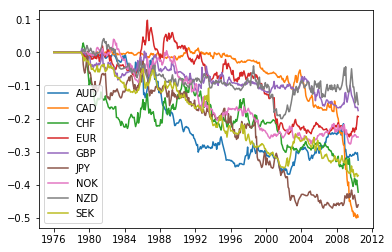

In [16]:
# Random Forest Regression with min_samples_leaf selected by 10-fold Cross Validation
param_grid = {"min_samples_leaf": [1, 3, 10]}
rfCumDiff = learnAndPlot(36, GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, cv = 10), 
                         fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)